<a href="https://colab.research.google.com/github/deivismartinez/NER-Medical-Uninorte/blob/main/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install spacy
!python -m spacy download es_core_news_md

In [ ]:
from transformers import pipeline, AutoTokenizer
import json
from pathlib import Path
from google.colab import files
from os import listdir
from os.path import isfile, join
import spacy
from matplotlib import pyplot as plt
from math import ceil
import shutil

In [ ]:
!wget https://zenodo.org/record/4279323/files/meddocan.zip?download=1 -O meddocan.zip

In [ ]:
!unzip meddocan.zip

In [ ]:
nlp = spacy.load("es_core_news_md")

In [ ]:
dataset = {}
for path in (Path('dev'), Path('test'), Path('train')):
    dir_path = Path('meddocan')/path/Path('brat')
    filenames = tuple(f[:-4] for f in listdir(dir_path) if isfile(join(dir_path, f)) if f[-4:] == '.txt')
    dataset[str(path)] = []
    for file_name in filenames:
      d = dict()
      with open(dir_path/Path(file_name+'.txt'), 'r') as f:
        dataset[str(path)].append({"text":f.read(),"file":file_name,"file_name_path":dir_path/Path(file_name+'.txt')})

In [ ]:
!wget https://raw.githubusercontent.com/deivismartinez/NER-Medical-Uninorte/main/tag.json

In [ ]:
def select_model(model_index):
  models = [
    {"name":"roberta-large-bne-capitel-ner", "folder":"PlanTL-GOB-ES/"},
    {"name":"roberta-base-bne-capitel-ner-plus", "folder":"PlanTL-GOB-ES/"},
    ]
  if model_index > len(models):
    print("Model index not exist, from 1 to "+str(len(models)))
    return None
  else:
    model = models[model_index-1].get("folder") + models[model_index-1].get("name")
    return model

In [ ]:
def get_ner_pipe(model):
  ner_pipe = pipeline(task="ner", model = model)
  return ner_pipe

In [ ]:
file = open("tag.json","r")
tag = json.load(file)
file.close()
def get_tag(entity):
  tags=["LOC","PER","ORG", "OTH"]
  for tag_l in tags:
    if tag_l in entity:
      return tag[tag_l]
  return "NEW TAG"

In [ ]:
def get_tokenizer(model):
  tokenizer = AutoTokenizer.from_pretrained(model,add_prefix_space=True)
  do_grafic(tokenizer)
  return tokenizer

In [ ]:
def do_grafic(tokenizer):
  token_length = [len(tokenizer(x.get('text'))['input_ids']) for x in dataset['train']]
  plt.hist(token_length)

In [ ]:
def change_start_end(list_values, n_string):
  for entity in list_values:
    entity["start"] = entity.get("start") + n_string
    entity["end"] = entity.get("end") + n_string
  return list_values

In [ ]:
def build_file(entity_list, file_name, min_score = 0.5):
  t = 0
  file= open(file_name,"w")
  end_last = -1
  word_last = ""
  for entity in entity_list:
      print('--------------Entity Actual::: ',entity['entity'],'-----------',entity['word'].replace('Ġ',' ').replace('Ã±','ñ').replace('Ã¡','á').replace('Ã©','é').replace('ÃŃ','í').replace('Ã³','ó').replace('Ãº','ú'))
      if entity['score'] > min_score:
        if entity['start'] == end_last or end_last == -1:
          word_last += entity['word']
          if end_last == -1:
            start_first = entity['start']
            entity_first = entity['entity']
        else:
          t += 1
          end_now = entity['end']
          entity_now = get_tag(entity_first)
          row = 'T'+str(t) +'\t'+ str(entity_now) +' ' + str(start_first) +' '+ str(end_last) +'\t' + word_last +'\n'
          file.write(row)
          word_last = entity['word']
          start_first = entity['start']
          entity_first = entity['entity']
        end_last = entity['end']
  t += 1
  entity_now = get_tag(entity_first)
  row = 'T'+str(t) +'\t'+ str(entity_now) +' ' + str(start_first) +' '+ str(end_last) +'\t' + word_last +'\n'
  file.write(row)
  file.close ()

In [ ]:
def build_file_new(entity_list, file_name, min_score = 0.5):
  t = 0
  file= open(file_name,"w")
  end_last = -1
  entity_last = ""
  word_last = ""
  for entity in entity_list:
      #print('--------------Entity Actual::: ',entity['entity'],'-----------',entity['word'].replace('Ġ',' ').replace('Ã±','ñ').replace('Ã¡','á').replace('Ã©','é').replace('ÃŃ','í').replace('Ã³','ó').replace('Ãº','ú'))
      if entity['score'] > min_score:
        if (entity['start'] == end_last or end_last == -1) or ((entity['start'] == (end_last+1)) 
        and get_tag(entity['entity']) == get_tag(entity_last)):
          word_last += entity['word']
          if end_last == -1:
            start_first = entity['start']
            entity_first = entity['entity']
        else:
          t += 1
          end_now = entity['end']
          entity_now = get_tag(entity_first)
          row = 'T'+str(t) +'\t'+ str(entity_now) +' ' + str(start_first) +' '+ str(end_last) +'\t' + word_last.replace('Ġ',' ').replace('Ã±','ñ').replace('Ã¡','á').replace('Ã©','é').replace('ÃŃ','í').replace('Ã³','ó').replace('Ãº','ú') +'\n'
          if(entity_now!='OTHER'):
            file.write(row)
          word_last = entity['word']
          start_first = entity['start']
          entity_first = entity['entity']
        end_last = entity['end']
        entity_last = entity['entity']
  t += 1
  entity_now = get_tag(entity_first)
  row = 'T'+str(t) +'\t'+ str(entity_now) +' ' + str(start_first) +' '+ str(end_last) +'\t' + word_last.replace('Ġ',' ').replace('Ã±','ñ').replace('Ã¡','á').replace('Ã©','é').replace('ÃŃ','í').replace('Ã³','ó').replace('Ãº','ú') +'\n'
  if(entity_now!='OTHER'):
    file.write(row)
  file.close ()

In [ ]:
def get_values_512(texto, ner_pipe, model_index=1):
  max_length = 512
  n_string = -1
  ner_output = []
  model = select_model(model_index)
  if model != None:
    tokenizer = get_tokenizer(model)
    tokens = tokenizer(texto)['input_ids']
    if len(tokens) > max_length:
      n_partitions = ceil(len(tokens) / max_length)
      for i in range(n_partitions):
        end_index = (i+1)*max_length
        if end_index > len(tokens):
          end_index  = len(tokens) - 1 
        token_sequence = tokens[i*max_length:end_index]
        string_sequence = tokenizer.decode(token_sequence, 
                                          skip_special_tokens=True,
                                          clean_up_tokenization_spaces=False)
        new_list = change_start_end(ner_pipe(string_sequence), n_string)
        ner_output.extend(new_list)
        n_string = n_string + len(string_sequence)
      if n_string != len(texto):
        print(f'Original length: {len(texto)} vs Decoded Size {n_string}')
    else:
      ner_output.extend(ner_pipe(texto))
  return ner_output

In [ ]:
def get_values_sents(nlp_var, ner_pipe):
  entity_list =  []
  sum = 0
  print(type(nlp_var))
  for text_npl in nlp_var.sents:
    for entity in ner_pipe(str(text_npl)):
      entity["start"] = entity.get("start") + sum
      entity["end"] = entity.get("end") + sum
      entity_list.append(entity)
    sum = sum + len(str(text_npl))
  return entity_list

In [ ]:
def get_values_split(text, ner_pipe):
  entity_list =  []
  text_split = text.split('.')
  sum = 0
  for text_npl in text_split:
    print(text_npl)
    for entity in ner_pipe(str(text_npl)):
      entity["start"] = entity.get("start") + sum
      entity["end"] = entity.get("end") + sum
      entity_list.append(entity)
    sum = sum + len(str(text_npl))
  return entity_list

In [ ]:
def prepare_file(text, file_name, folder_system, min_score,
                 type_text, ner_pipe, model_index):
  file_ann_name = folder_system + file_name + ".ann"
  nlp_var = nlp(text)
  entity_list = []
  if type_text == 0:
    entity_list = ner_pipe(str(nlp_var))
  elif type_text == 1:
    entity_list = get_values_sents(nlp_var, ner_pipe = ner_pipe)
  elif type_text == 2:
    entity_list = get_values_512(text, ner_pipe = ner_pipe,
                                 model_index=model_index)
  elif type_text == 3:
    entity_list = get_values_split(text, ner_pipe = ner_pipe)
  else:
    print("Type not exist")
  if len(entity_list) > 0:
    build_file_new(entity_list,file_ann_name, min_score = min_score)

In [ ]:
def builder(min_score, quantity = 1, type_text = 0, model_index = 1):
  model = select_model(model_index)
  if model != None:
    ner_pipe = get_ner_pipe(model)
    folder_system = "system/model_"+str(model_index)+"/test"+str(type_text)+"/"
    folder_gold = "system/gold/"
    if not Path(folder_system).exists():
      path = Path(folder_system)
      path.mkdir(parents=True)
    if not Path(folder_gold).exists():
      path = Path(folder_gold)
      path.mkdir(parents=True)
    for text in dataset['test']:
      #if text.get('file') == 'S0211-69952014000600016-1':
      path_completo = str(text.get('file_name_path'))
      path_completo = path_completo[:-4]
      prepare_file(text.get('text'), text.get('file'), folder_system,
                  min_score = min_score, type_text = type_text,
                  ner_pipe = ner_pipe, model_index = model_index)
      shutil.copy(path_completo+".txt", folder_gold+text.get('file')+".txt")
      shutil.copy(path_completo+".ann", folder_gold+text.get('file')+".ann")
      shutil.copy(path_completo+".txt", folder_system+text.get('file')+".txt")
      quantity -= 1
      if quantity < 1:
        break

In [ ]:
builder(type_text = 3, min_score = 0.0, quantity = 1, model_index = 2)

Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

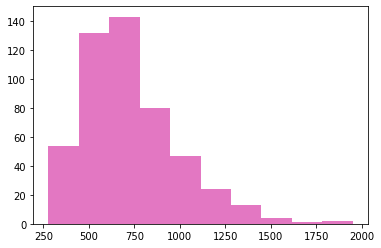

In [ ]:
#Las tablas finales con el de test y desarrollo con train
builder(type_text = 2, min_score = 0.0, quantity = 7, model_index = 1)

In [ ]:
builder(type_text = 1, min_score = 0.0, quantity = 1, model_index = 2)

In [ ]:
builder(type_text = 0, min_score = 0.0, quantity = 1, model_index = 2)

In [ ]:
import os
import zipfile
fantasy_zip = zipfile.ZipFile('/content/systemd.zip', 'w')
for folder, subfolders, files in os.walk('/content/system'): 
    for file in files:
        if file.endswith('.ann') or file.endswith('.txt'):
            fantasy_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), '/content/system'), compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()

In [ ]:
def remove_file():
  from pathlib import Path
  folder_system = "/content/system/"
  folder = Path(folder_system)
  for file in folder.iterdir():
    try:
      file_name = file.name[0:len(file.name)-4]
      filePath=Path(folder_system+file_name+".ann")
      filePath.unlink()
    except OSError as e:
      print(f"Error:{ e.strerror}")